In [1]:
import torch
from torch import nn
from torch.optim import SGD, Adam
from annpy.models.gan import GAN
from annpy.training import GANTrainer
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchtrainer.callbacks import Logger
from torchtrainer.utils.data.datasets import UnsuperviseDataset
import matplotlib.pyplot as plt


WIDTH=28
HEIGHT=28
USE_CUDA=True

In [2]:
generator = nn.Sequential(nn.Linear(in_features=64, out_features=1000),
                          nn.BatchNorm1d(1000),
                          nn.ReLU(inplace=True),
                          nn.Dropout(p=0.5),
                          nn.Linear(in_features=1000, out_features=28*28),
                          nn.Sigmoid(),
                          nn.Dropout(p=0.1),
                         )
generator.input_shape = (64,)

In [3]:
discriminator = nn.Sequential(nn.Linear(in_features=28*28, out_features=1000),
                              nn.BatchNorm1d(1000),
                              nn.ReLU(inplace=True),
                              nn.Dropout(p=0.5),
                              nn.Linear(in_features=1000, out_features=1),
                              )

In [4]:
m = GAN(generator=generator, discriminator=discriminator)

In [5]:
m.generator

Sequential(
  (0): Linear(in_features=64, out_features=1000, bias=True)
  (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Dropout(p=0.5)
  (4): Linear(in_features=1000, out_features=784, bias=True)
  (5): Sigmoid()
  (6): Dropout(p=0.1)
)

In [6]:
m.generator.input_shape

(64,)

In [7]:
m.discriminator

Sequential(
  (0): Linear(in_features=784, out_features=1000, bias=True)
  (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Dropout(p=0.5)
  (4): Linear(in_features=1000, out_features=1, bias=True)
)

In [19]:
def showsample():
    sample = m.sample(1).data[0]
    im = sample.view(WIDTH,HEIGHT)
    if USE_CUDA:
        im = im.cpu()
    plt.imshow(im.numpy())
    plt.colorbar()
    plt.show()

In [9]:
g_optimizer = Adam(m.generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
d_optimizer = Adam(m.discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))

In [10]:
trainer = GANTrainer(m,
                     d_optimizer,
                     g_optimizer,
                     callbacks=[Logger()],
                     logging_frecuency=50,
                     soft_labels_eps=0)

In [11]:
transform = transforms.Compose([transforms.Resize((WIDTH, HEIGHT)),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.5,), (1.005,)),
                                transforms.Lambda(lambda x: x.view(-1))])

In [12]:
train_ds = UnsuperviseDataset(MNIST(root='data', download=True, train=False, transform=transform))
test_ds = UnsuperviseDataset(MNIST(root='data', download=False, train=False, transform=transform))

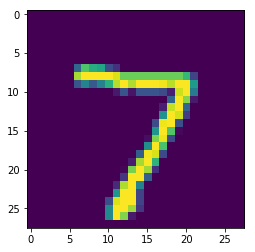

In [13]:
plt.imshow(train_ds[0].view(WIDTH,HEIGHT).cpu().numpy())
plt.show()

In [14]:
dataloader = DataLoader(train_ds, batch_size=512)
test_dl = DataLoader(test_ds, batch_size=512)

In [15]:
if USE_CUDA:
    trainer.cuda()

In [16]:
trainer.train(dataloader,
              valid_dataloader=test_dl,
              epochs=30)

epoch: 0/30,	step: 19/20,	train_loss: 1.345,	train_g_loss: 0.669,	train_d_loss: 0.676,	val_loss: 1.840,	val_g_loss: 0.769,	val_d_loss: 1.071
epoch: 1/30,	step: 19/20,	train_loss: 1.204,	train_g_loss: 0.590,	train_d_loss: 0.613,	val_loss: 3.025,	val_g_loss: 0.947,	val_d_loss: 2.078
epoch: 2/30,	step: 19/20,	train_loss: 1.058,	train_g_loss: 0.512,	train_d_loss: 0.545,	val_loss: 2.941,	val_g_loss: 0.909,	val_d_loss: 2.031
epoch: 3/30,	step: 19/20,	train_loss: 0.923,	train_g_loss: 0.441,	train_d_loss: 0.482,	val_loss: 2.369,	val_g_loss: 0.698,	val_d_loss: 1.672
epoch: 4/30,	step: 19/20,	train_loss: 0.778,	train_g_loss: 0.372,	train_d_loss: 0.406,	val_loss: 2.005,	val_g_loss: 0.275,	val_d_loss: 1.730
epoch: 5/30,	step: 19/20,	train_loss: 0.657,	train_g_loss: 0.311,	train_d_loss: 0.346,	val_loss: 2.871,	val_g_loss: 0.081,	val_d_loss: 2.790
epoch: 6/30,	step: 19/20,	train_loss: 0.546,	train_g_loss: 0.259,	train_d_loss: 0.287,	val_loss: 3.825,	val_g_loss: 0.030,	val_d_loss: 3.795
epoch: 7/30,	

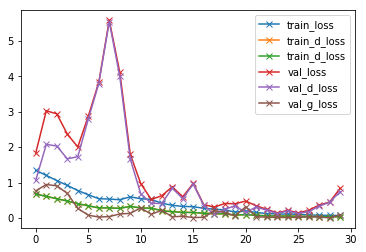

In [17]:
trainer.history.epoch_plot('train_loss')
trainer.history.epoch_plot('train_d_loss')
trainer.history.epoch_plot('train_d_loss')
trainer.history.epoch_plot('val_loss')
trainer.history.epoch_plot('val_d_loss')
trainer.history.epoch_plot('val_g_loss')
plt.legend()
plt.show()

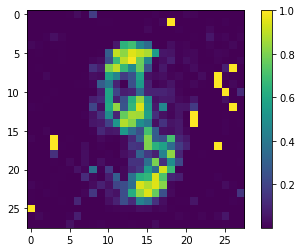

In [25]:
m.eval()
showsample()

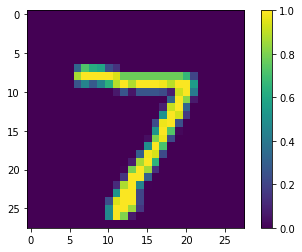

In [23]:
plt.imshow(train_ds[0].view(28,28).numpy())
plt.colorbar()
plt.show()